# Basic Functionality

In [1]:
# import all revelant packages
from headers import *
import matplotlib

In [2]:
#make plots prettier
matplotlib.rcParams['axes.linewidth'] = 4 
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = 40
matplotlib.rcParams['xtick.labelsize'] = 30 
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['legend.fontsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 15
matplotlib.rcParams['ytick.major.size'] = 15
matplotlib.rcParams['xtick.minor.size'] = 7.5
matplotlib.rcParams['ytick.minor.size'] = 7.5
matplotlib.rcParams['xtick.major.width'] = 5
matplotlib.rcParams['ytick.major.width'] = 5
matplotlib.rcParams['xtick.minor.width'] = 2.5
matplotlib.rcParams['ytick.minor.width'] = 2.5

## Defining a cosmology

A forecast requires a cosmology and an experiment. Let's first go ahead and define our fidicual cosmology.

In [3]:
params = {
          'output': 'mPk',
          'P_k_max_h/Mpc': 40.,
          'non linear':'halofit', 
          'non linear':'HMCode',
          'z_pk': '0.0,10',
          'A_s': 2.10732e-9,
          'n_s': 0.96824,
          'h': 0.6770,
          'N_ur': 2.0328,
          'N_ncdm': 1,
          'm_ncdm': 0.06,
          'tau_reio': 0.0568,
          'omega_b': 0.02247,
          'omega_cdm': 0.11923}

cosmo = Class()
cosmo.set(params)
cosmo.compute()

## Creating an experiment

Let's create an experiment that survery galaxies in a redshift range $0.8<z<1.2$. We assume that the number density of the galaxies is constant $n=0.001 \text{ [h/Mpc]}^{3}$, and that each galaxy's redshift can be measured with uncertainty $\sigma_z/(1+z)=0.0$. For simplicity we'll just lump the survey into one redshift bin.

In [4]:
exp = experiment(zmin=0.8,zmax=1.2,n=1e-3,nbins=1,sigma_z=0.)

## Creating a forecast: calculating power spectra and derivatives

In [5]:
fishcast = fisherForecast(experiment=exp,cosmo=cosmo,params=params,khmax=0.2,Nk=200,Nmu=200)
# Let's choose the parameters to marginalize over
fishcast.marg_params = np.array(['omega_b','omega_cdm','h'])

fisherForecast objects automatically calculate the fidicual galaxy power spectrum at the centers of each redshift bin. This includes the effects of RSD and redshift errors (if desired). Below is a plot of the observed galaxy power spectrum $P^\text{obs}_g(k,\mu=0)$ at $z=1$, including redshift errors and RSD.

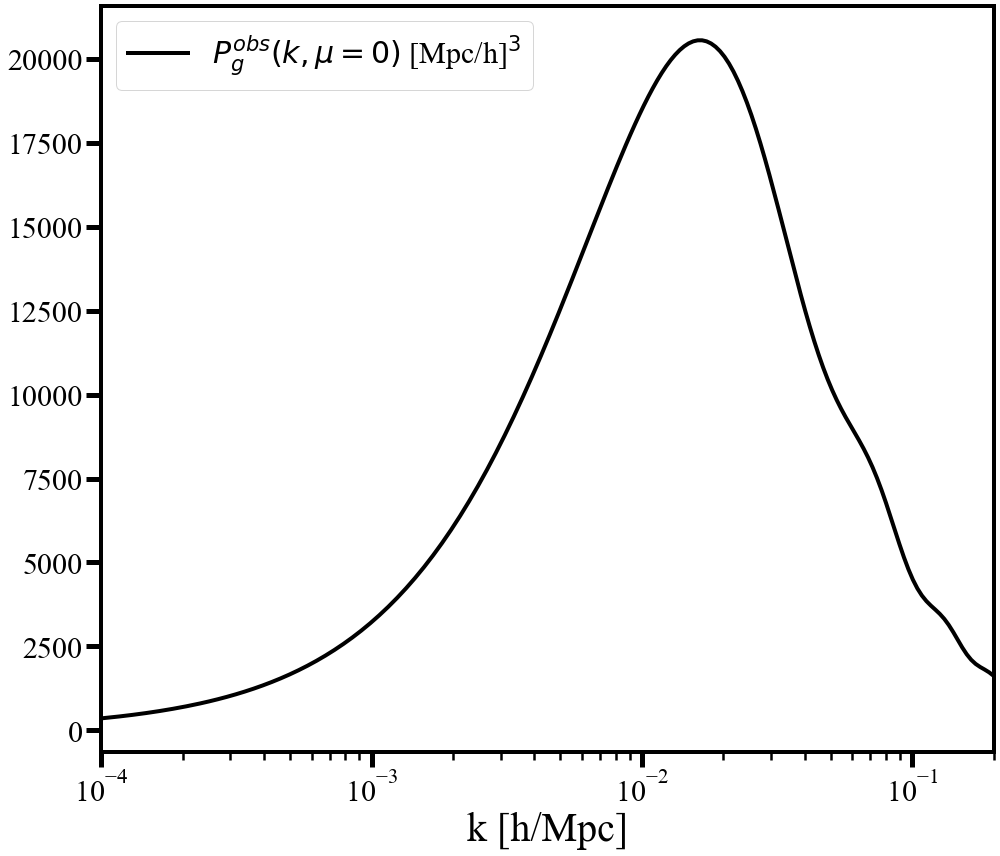

In [6]:
fishcast.pretty_plot(fishcast.k,[fishcast.P_fid[0]],xlabel=r'k [h/Mpc]',c='k',datalabels=[r'$P_g^{obs}(k,\mu=0)$ [Mpc/h]$^3$'])

We can also take derivatives the fidicual power spectrum with respect to any of the cosmological parameters. The default derivative is a two point derivative $[f(x+\epsilon)-f(x-\epsilon)]/2\epsilon$ with a relative step size of 1%. Below is a plot of $dP^\text{obs}_g(k,\mu=0)/dh$ and $dP^\text{obs}_g(k,\mu=0)/d\Omega_b$ at $z=1$.

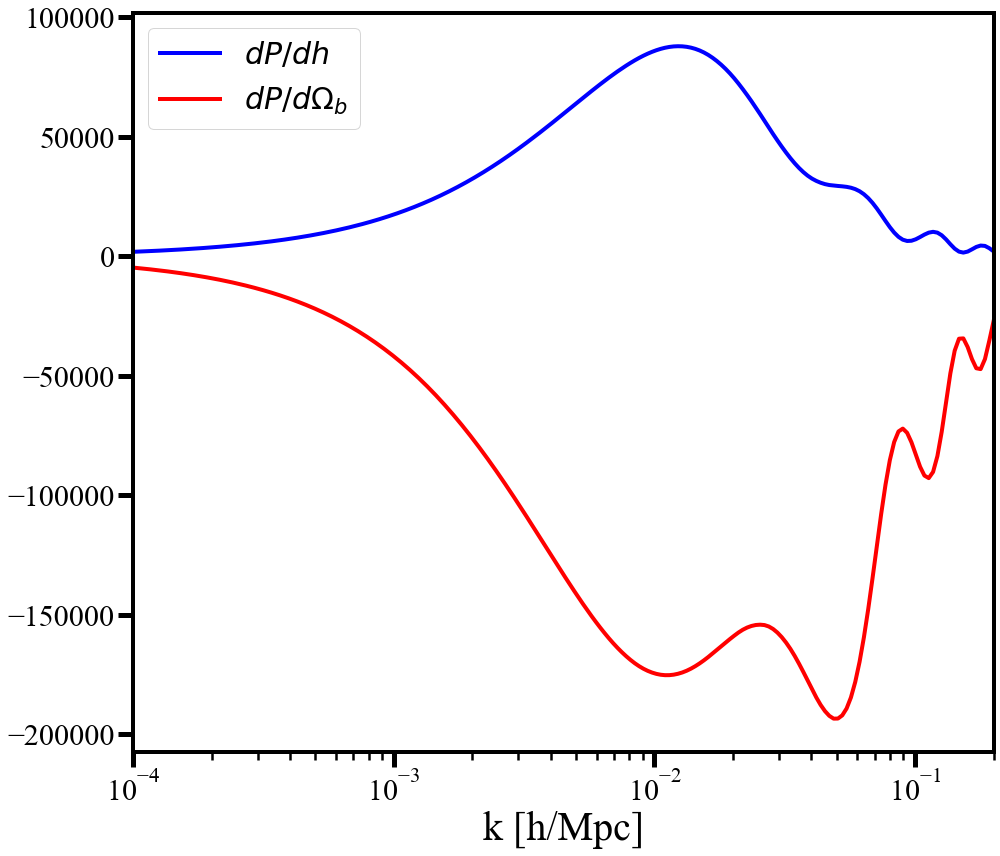

In [7]:
dPdh = fishcast.compute_dPdp(param='h',z=exp.zcenters[0])
dPdomega_b = fishcast.compute_dPdp(param='omega_b',z=exp.zcenters[0])
fishcast.pretty_plot(fishcast.k,[dPdh,dPdomega_b],xlabel=r'k [h/Mpc]',c=['b','r'],datalabels=[r'$dP/dh$',r'$dP/d\Omega_b$'])

We can also take one sided derivatives $-(3/2)[f(x) - (4/3) f(x+\epsilon) + f(x+2\epsilon)]/\epsilon$

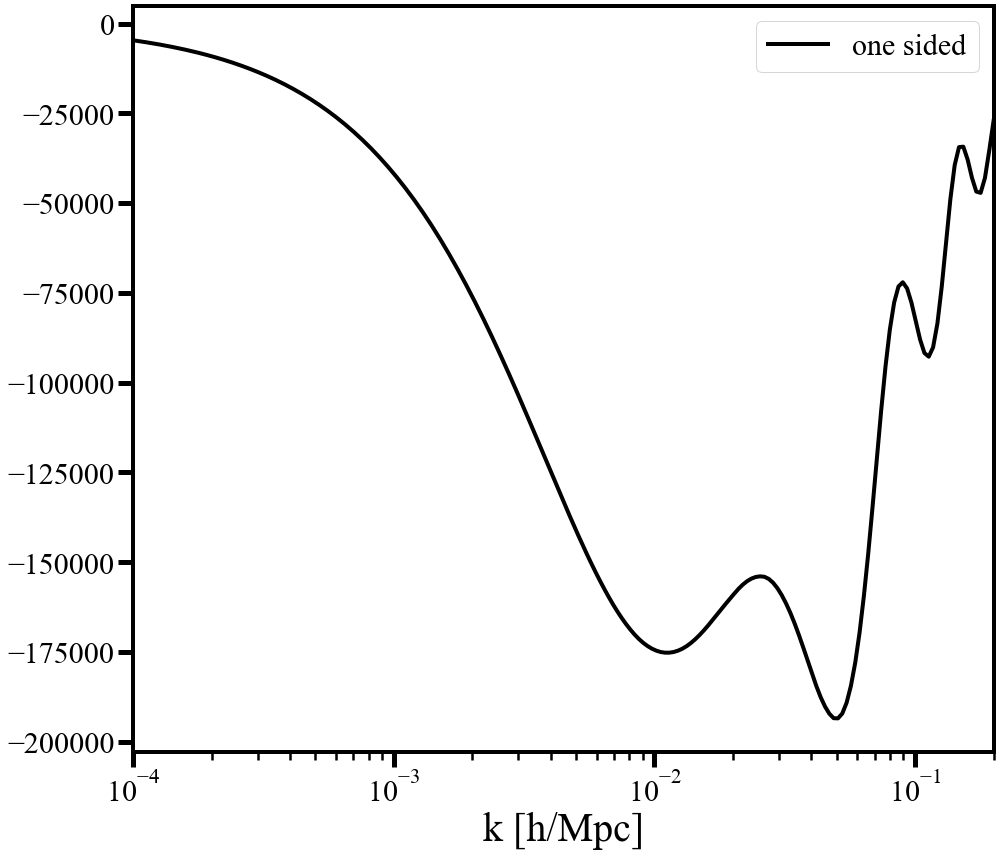

In [8]:
dPdomega_b_one_sided = fishcast.compute_dPdp(param='omega_b',z=exp.zcenters[0],one_sided=True)
fishcast.pretty_plot(fishcast.k,[dPdomega_b_one_sided],xlabel=r'k [h/Mpc]',c=['k'],datalabels=['one sided'])

The two methods agree extremely well.

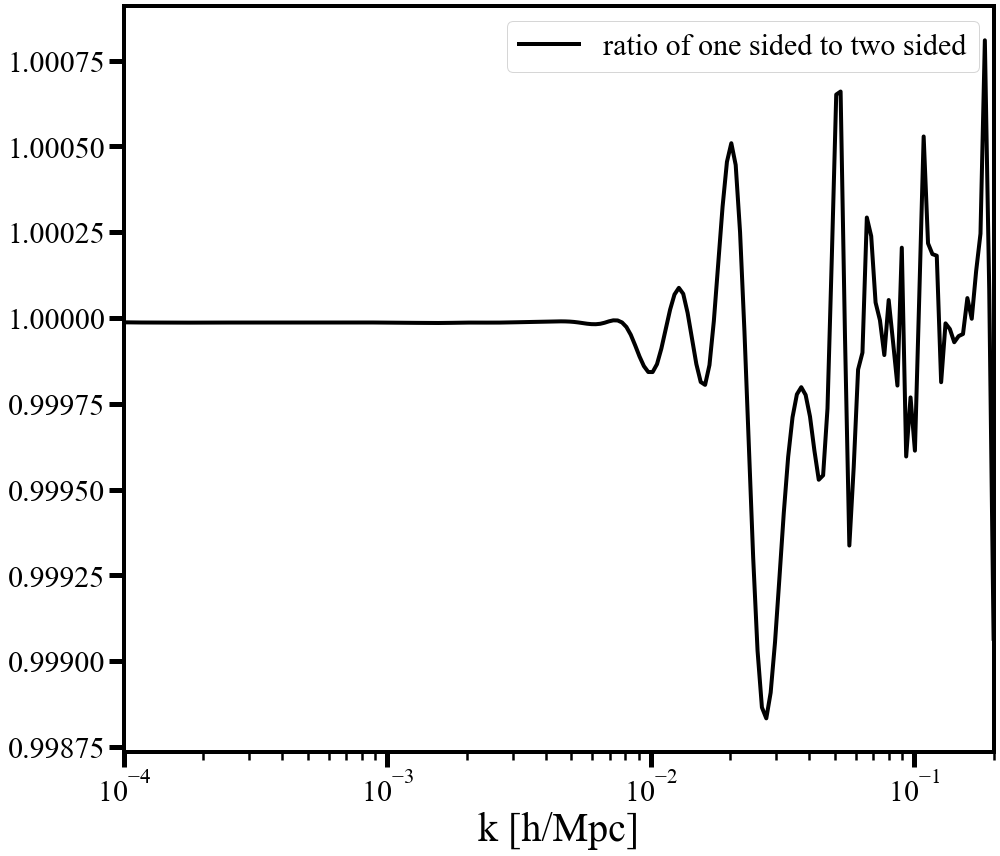

In [9]:
fishcast.pretty_plot(fishcast.k,[dPdomega_b_one_sided/dPdomega_b],xlabel=r'k [h/Mpc]',c=['k'],datalabels=['ratio of one sided to two sided'])

### Accuracy of derivatives
Below is a plot of the ratio of the two point derivative to the five point derivative (for $\Omega_b$ and $h$). They agree to within 0.5% of each other

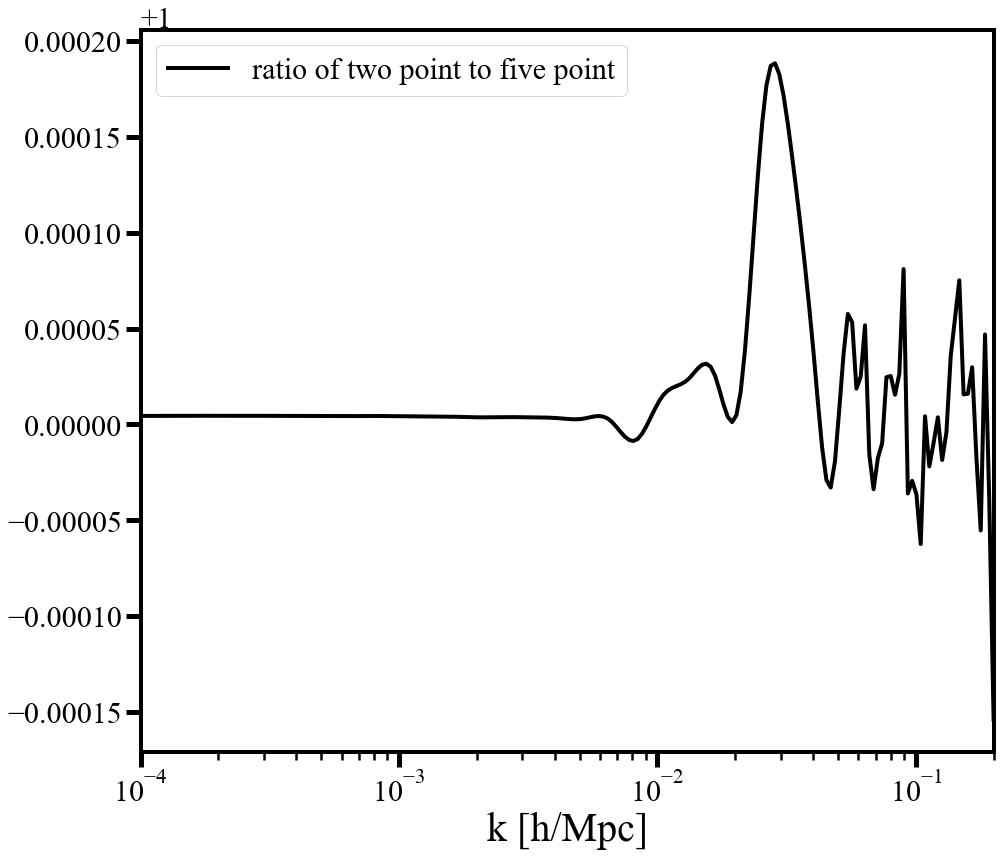

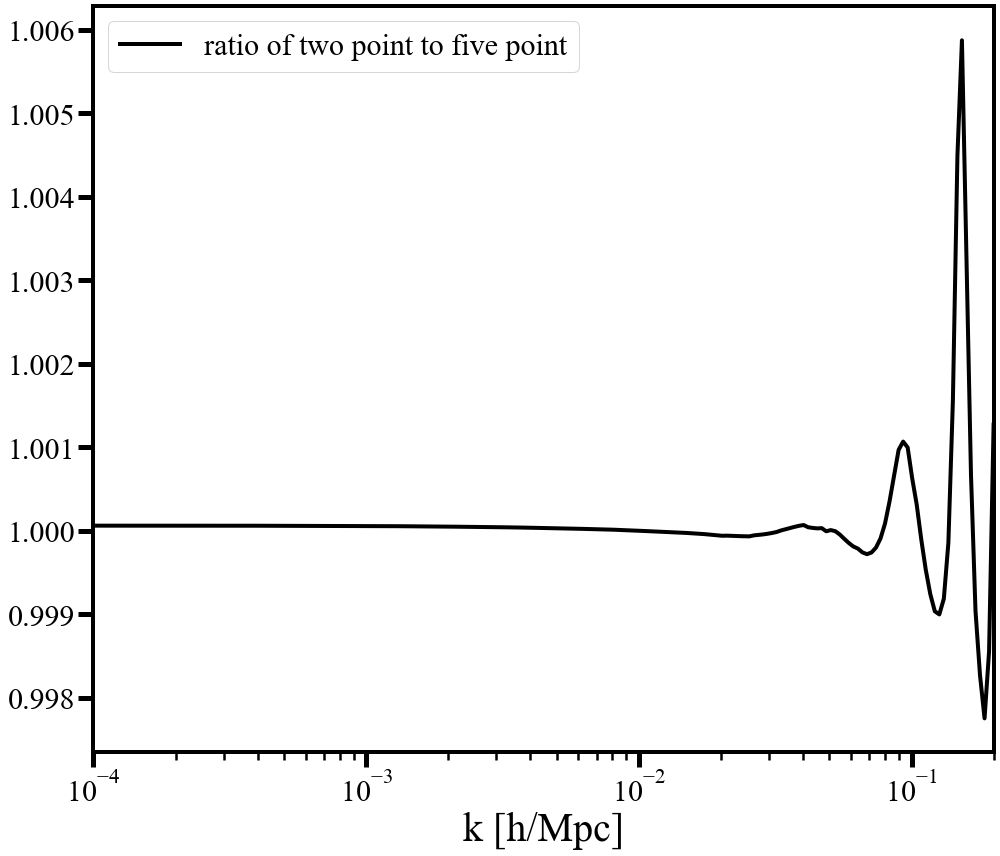

In [10]:
dPdomega_b_five_point = fishcast.compute_dPdp(param='omega_b', z=exp.zcenters[0], five_point=True)
fishcast.pretty_plot(fishcast.k,[dPdomega_b/dPdomega_b_five_point],xlabel=r'k [h/Mpc]',c=['k'],datalabels=['ratio of two point to five point'])


dPdh_five_point = fishcast.compute_dPdp(param='h', z=exp.zcenters[0], five_point=True)
fishcast.pretty_plot(fishcast.k,[dPdh/dPdh_five_point],xlabel=r'k [h/Mpc]',c=['k'],datalabels=['ratio of two point to five point'])

### Covariance matrix

We can also compute the covariance matrix. Below is a plot of the diagonal elements 

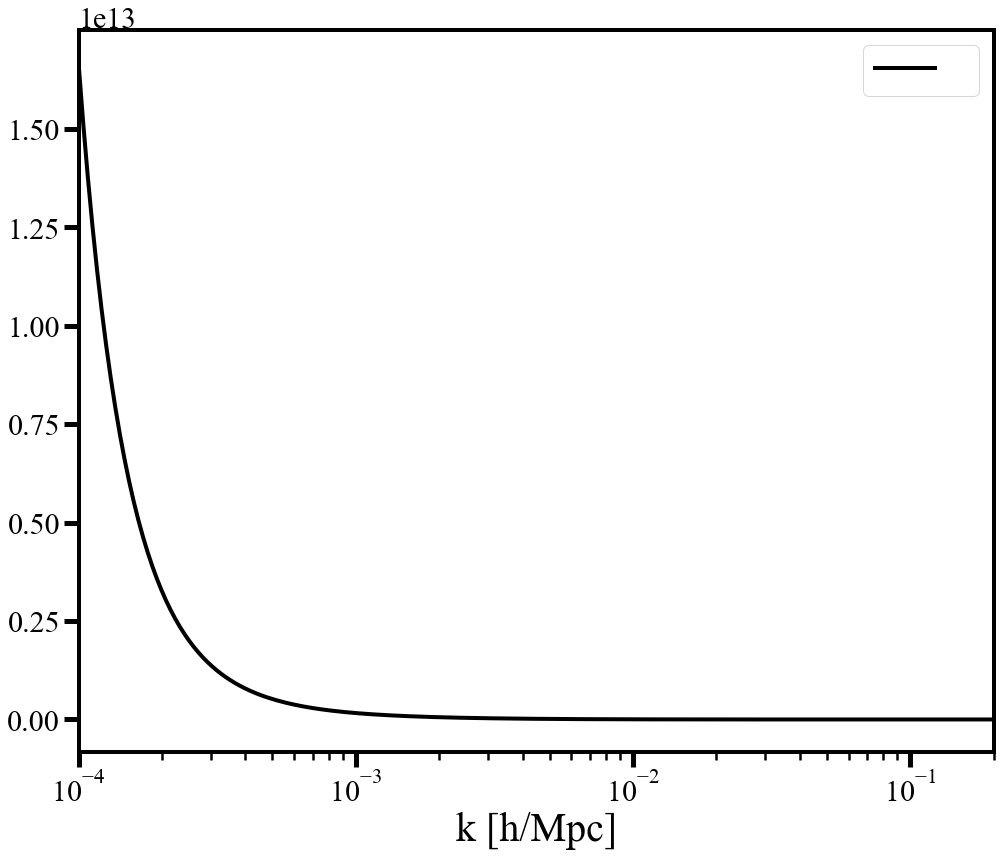

In [11]:
c = fishcast.get_covariance_matrix(0)
fishcast.pretty_plot(fishcast.k,[np.diag(c)],xlabel=r'k [h/Mpc]',c=['k'],datalabels=[' '])

The Fisher matrix can be computed using

In [12]:
F = fishcast.compute_Fisher_matrix()

And the relative errors on the parameters that we chose to margenalize over can be found using

In [13]:
fishcast.print_marginalized_errors(F=F)

Error on omega_b: 0.0006134916387136749
Error on omega_cdm: 0.0007205051144278374
Error on h: 0.0036180194783722035


We can also display these errors with ellipses. The two regions represent 68 and 95 percent confidence intervals.

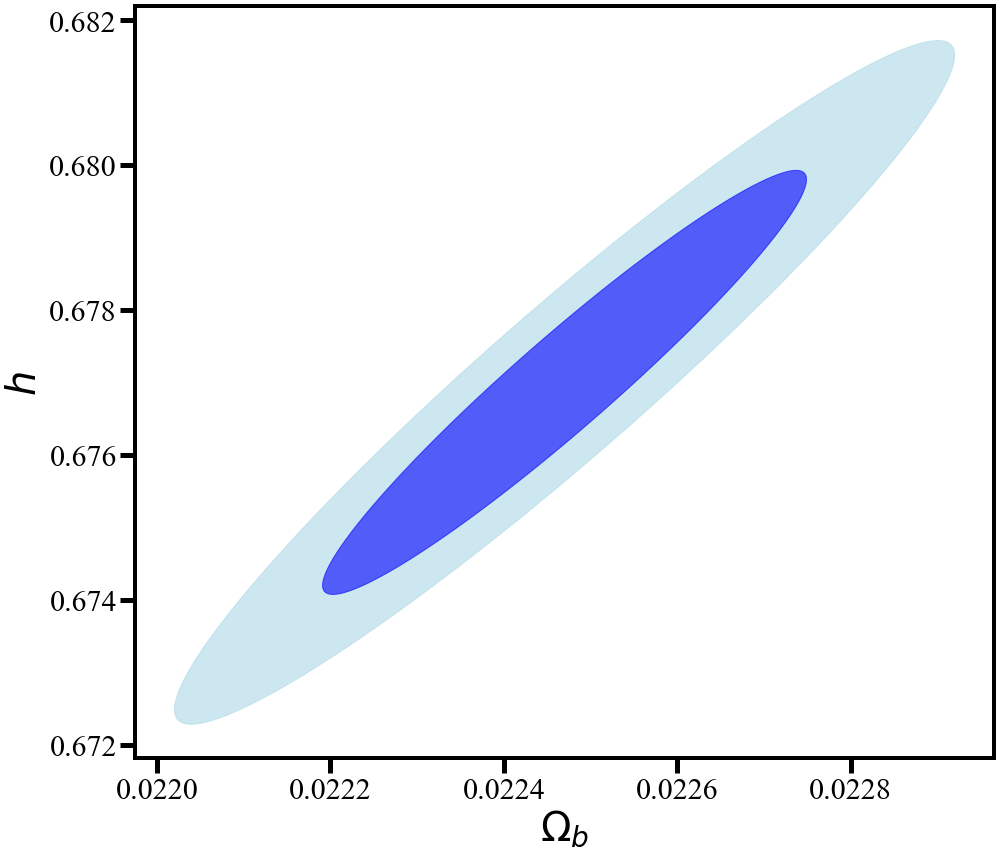

In [14]:
fishcast.plot_error_ellipse(F=F,param1='omega_b',param2='h')

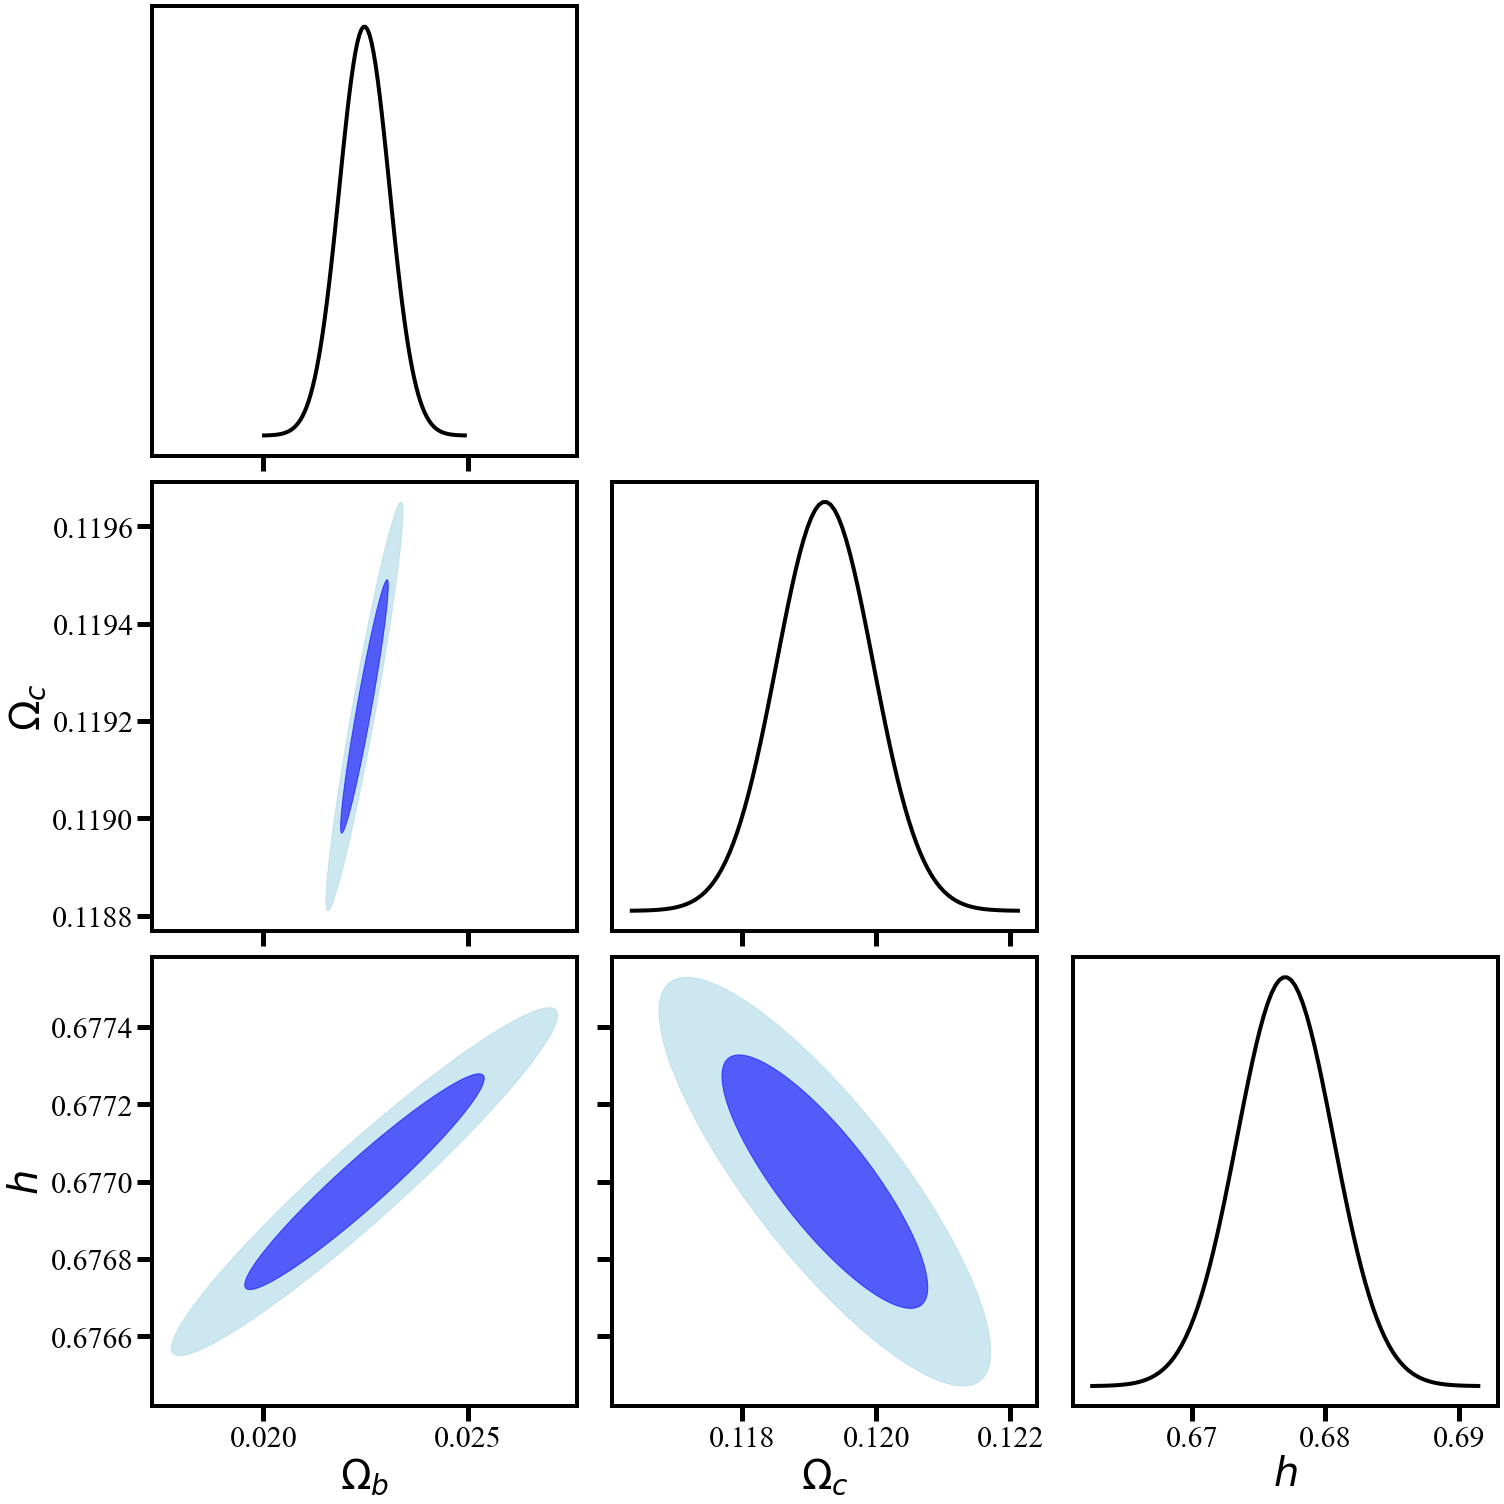

In [15]:
fishcast.plot_posterior_matrix(F=F)

## Megamapper-like experiment with Lyman-break galaxies
Megamapper will survey galaxies in the range $2<z<5$. Let's try a simple binning technique with evenly spaced redshift bins, each with $\Delta z=1$.

The number density $n(z)$ and the LBG bias are from Wilson and White 2019. These are "activated" by setting the flag LBG = True.

In [16]:
megaMapper = experiment(zmin=2., zmax=5., nbins=3, fsky=0.5, sigma_z=0.01, LBG=True)
megaCast = fisherForecast(experiment=megaMapper,cosmo=cosmo,params=params)
megaCast.marg_params = np.array(['log(A_s)','n_s','h','omega_b','m_ncdm','omega_cdm'])

The full Fisher matrix is a sum of Fisher matrices for each redshift bin. Therefore the time that it takes to compute the Fisher matrix scales linearly with the number of redshift bins, which is why this takes a little longer than before.

In [17]:
F = megaCast.compute_Fisher_matrix()

In [18]:
megaCast.print_marginalized_errors(F=F)

Error on log(A_s): 0.009134231035674465
Error on n_s: 0.0023555286293520496
Error on h: 0.003420737865417608
Error on omega_b: 0.0003645109648147025
Error on m_ncdm: 0.009779830187132278
Error on omega_cdm: 0.0011114177468041439


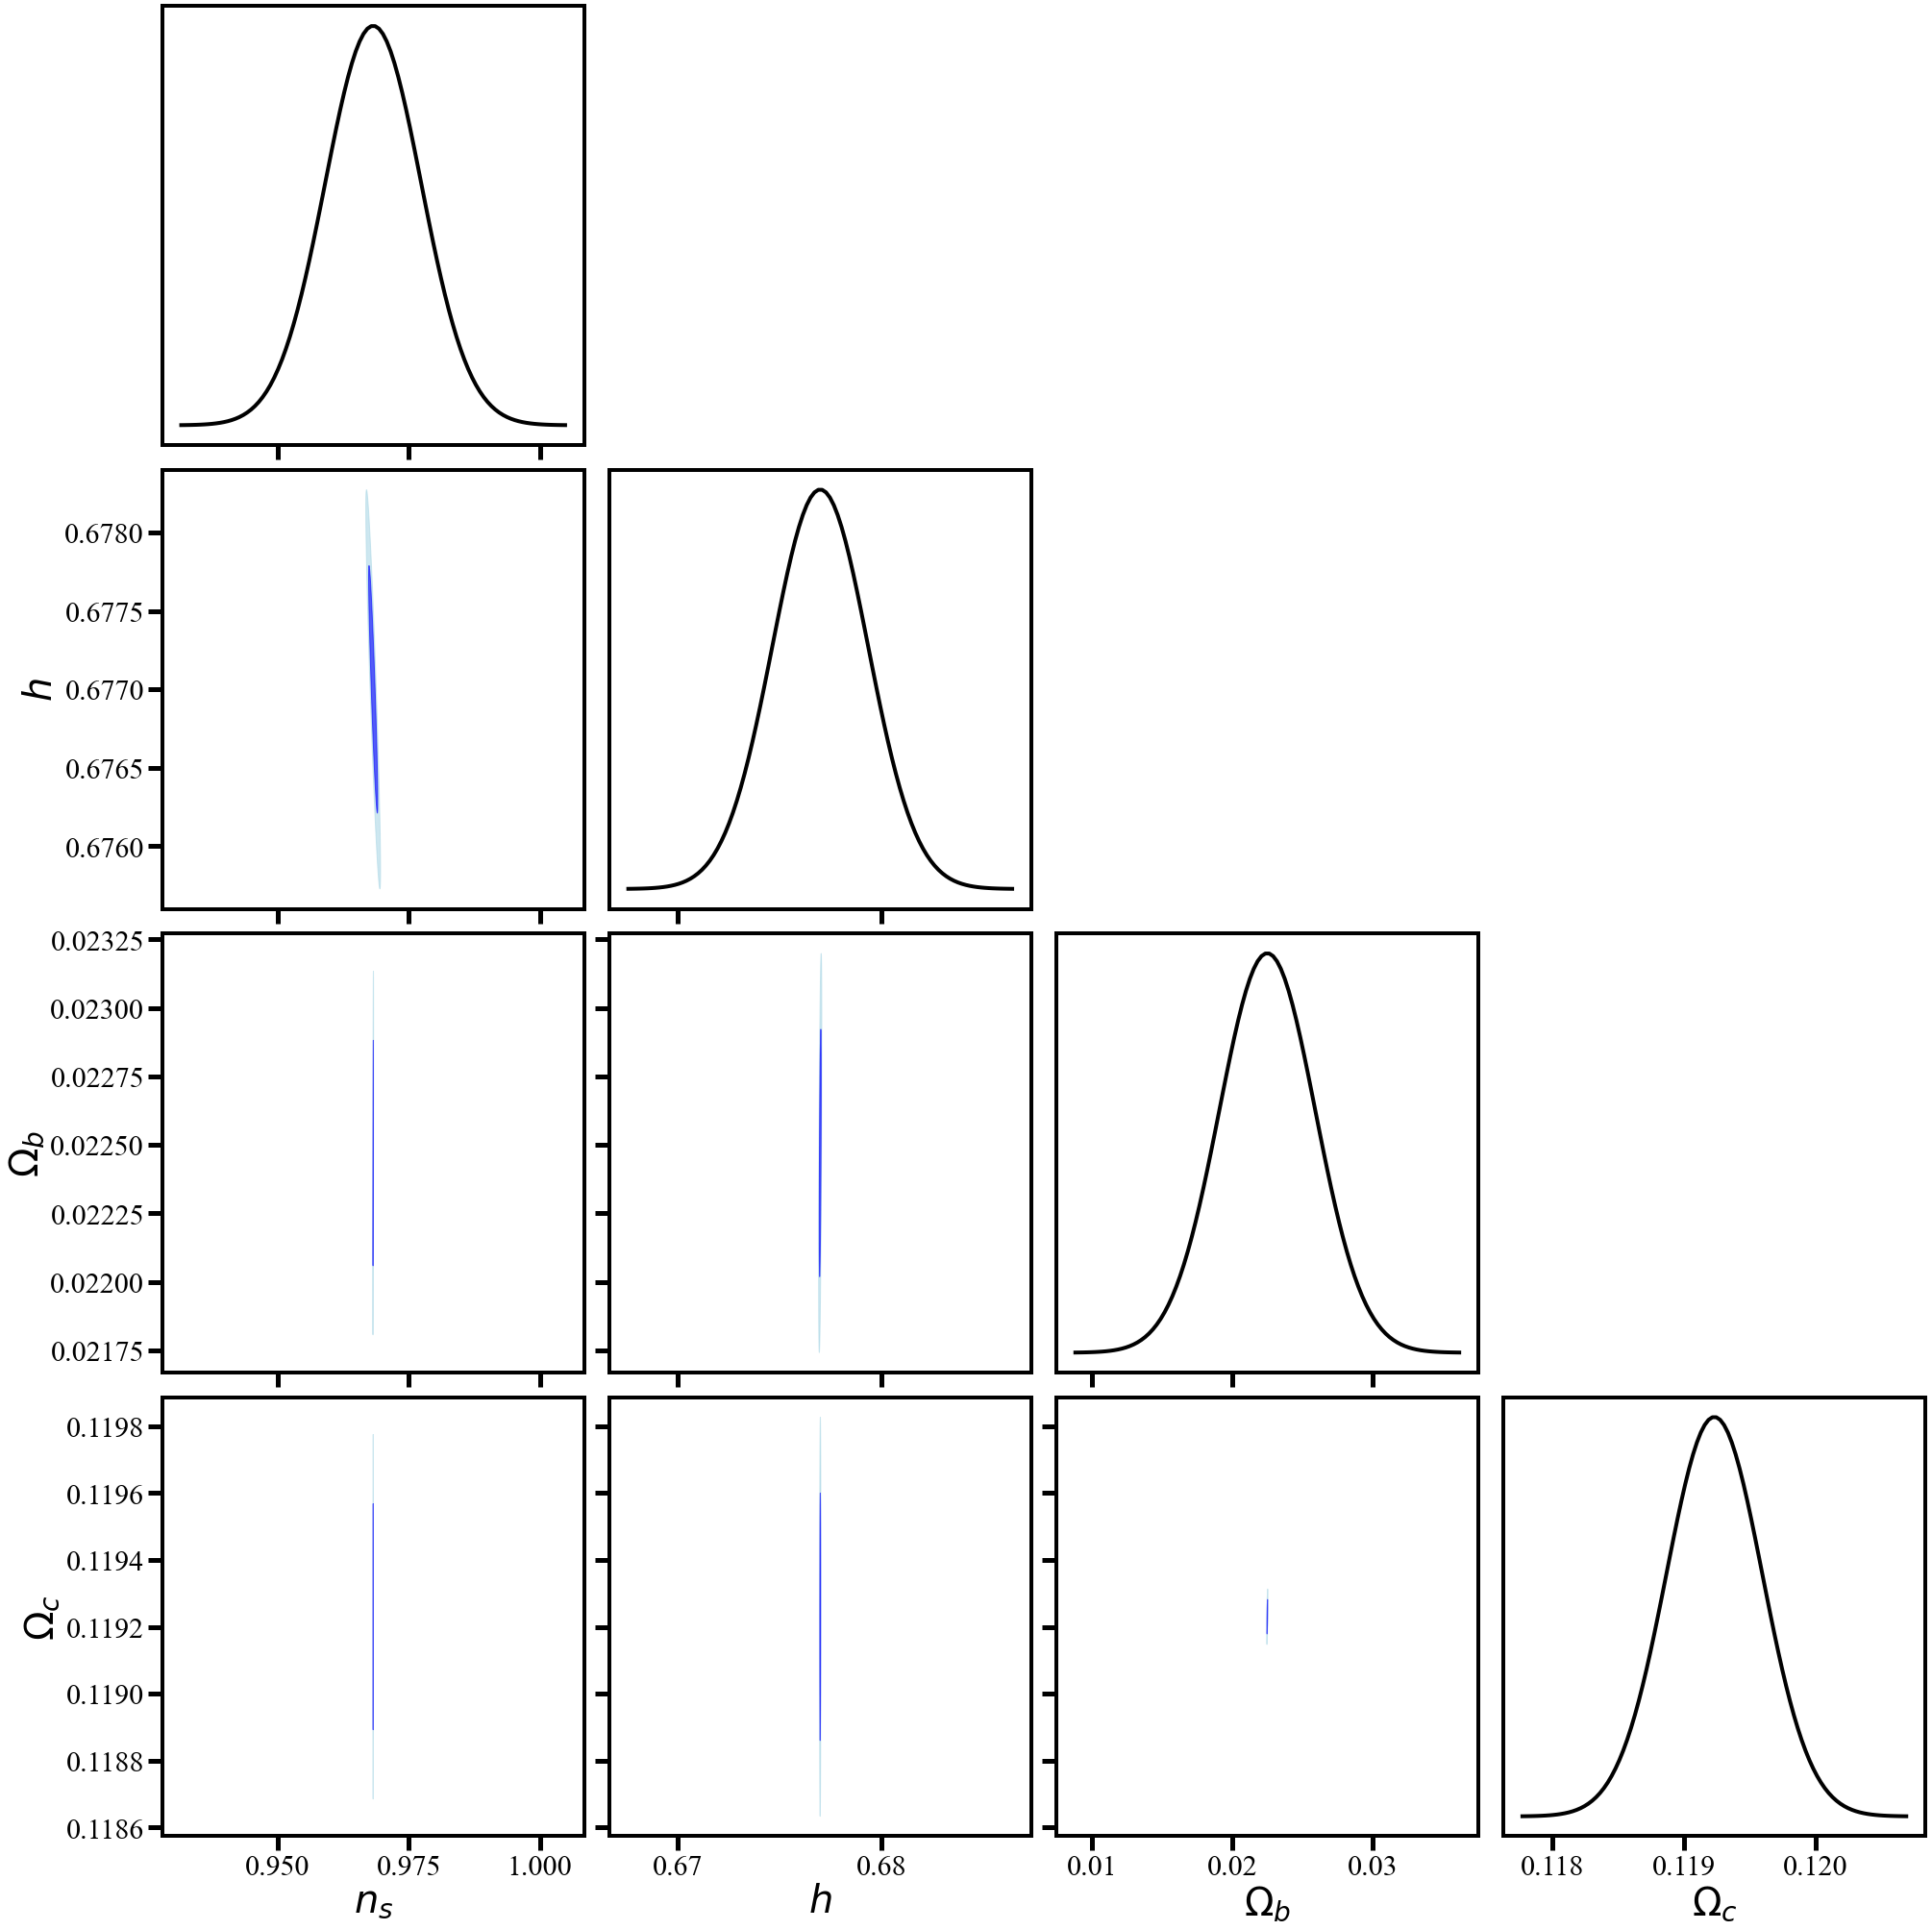

In [19]:
megaCast.plot_posterior_matrix(F=F,param_subset=np.array(['n_s','h','omega_b','omega_cdm']))

## PUMA-like experiment
PUMA would be a Hydrogen intensity survey from $2<z<6$. Let's assume we have 4 evenly spaced redshift bins.

The HI bias and noise model are from https://arxiv.org/pdf/1810.09572. They can be activated by setting HI = True for our experiment.

In [20]:
puma = experiment(zmin=2, zmax=6, nbins=4, fsky=0.5, sigma_z=0.01, HI=True)
marg_params = np.array(['log(A_s)','n_s','h','omega_b','m_ncdm','omega_cdm'])
pumaCast = fisherForecast(experiment=puma,cosmo=cosmo,params=params,marg_params=marg_params)

In [21]:
F = pumaCast.compute_Fisher_matrix()

In [22]:
pumaCast.print_marginalized_errors(F=F)

Error on log(A_s): 0.0007986471733482318
Error on n_s: 0.0005141334124416259
Error on h: 0.00041216480271054465
Error on omega_b: 8.737635985680165e-05
Error on m_ncdm: 0.004878275728428574
Error on omega_cdm: 0.00010953190197086325


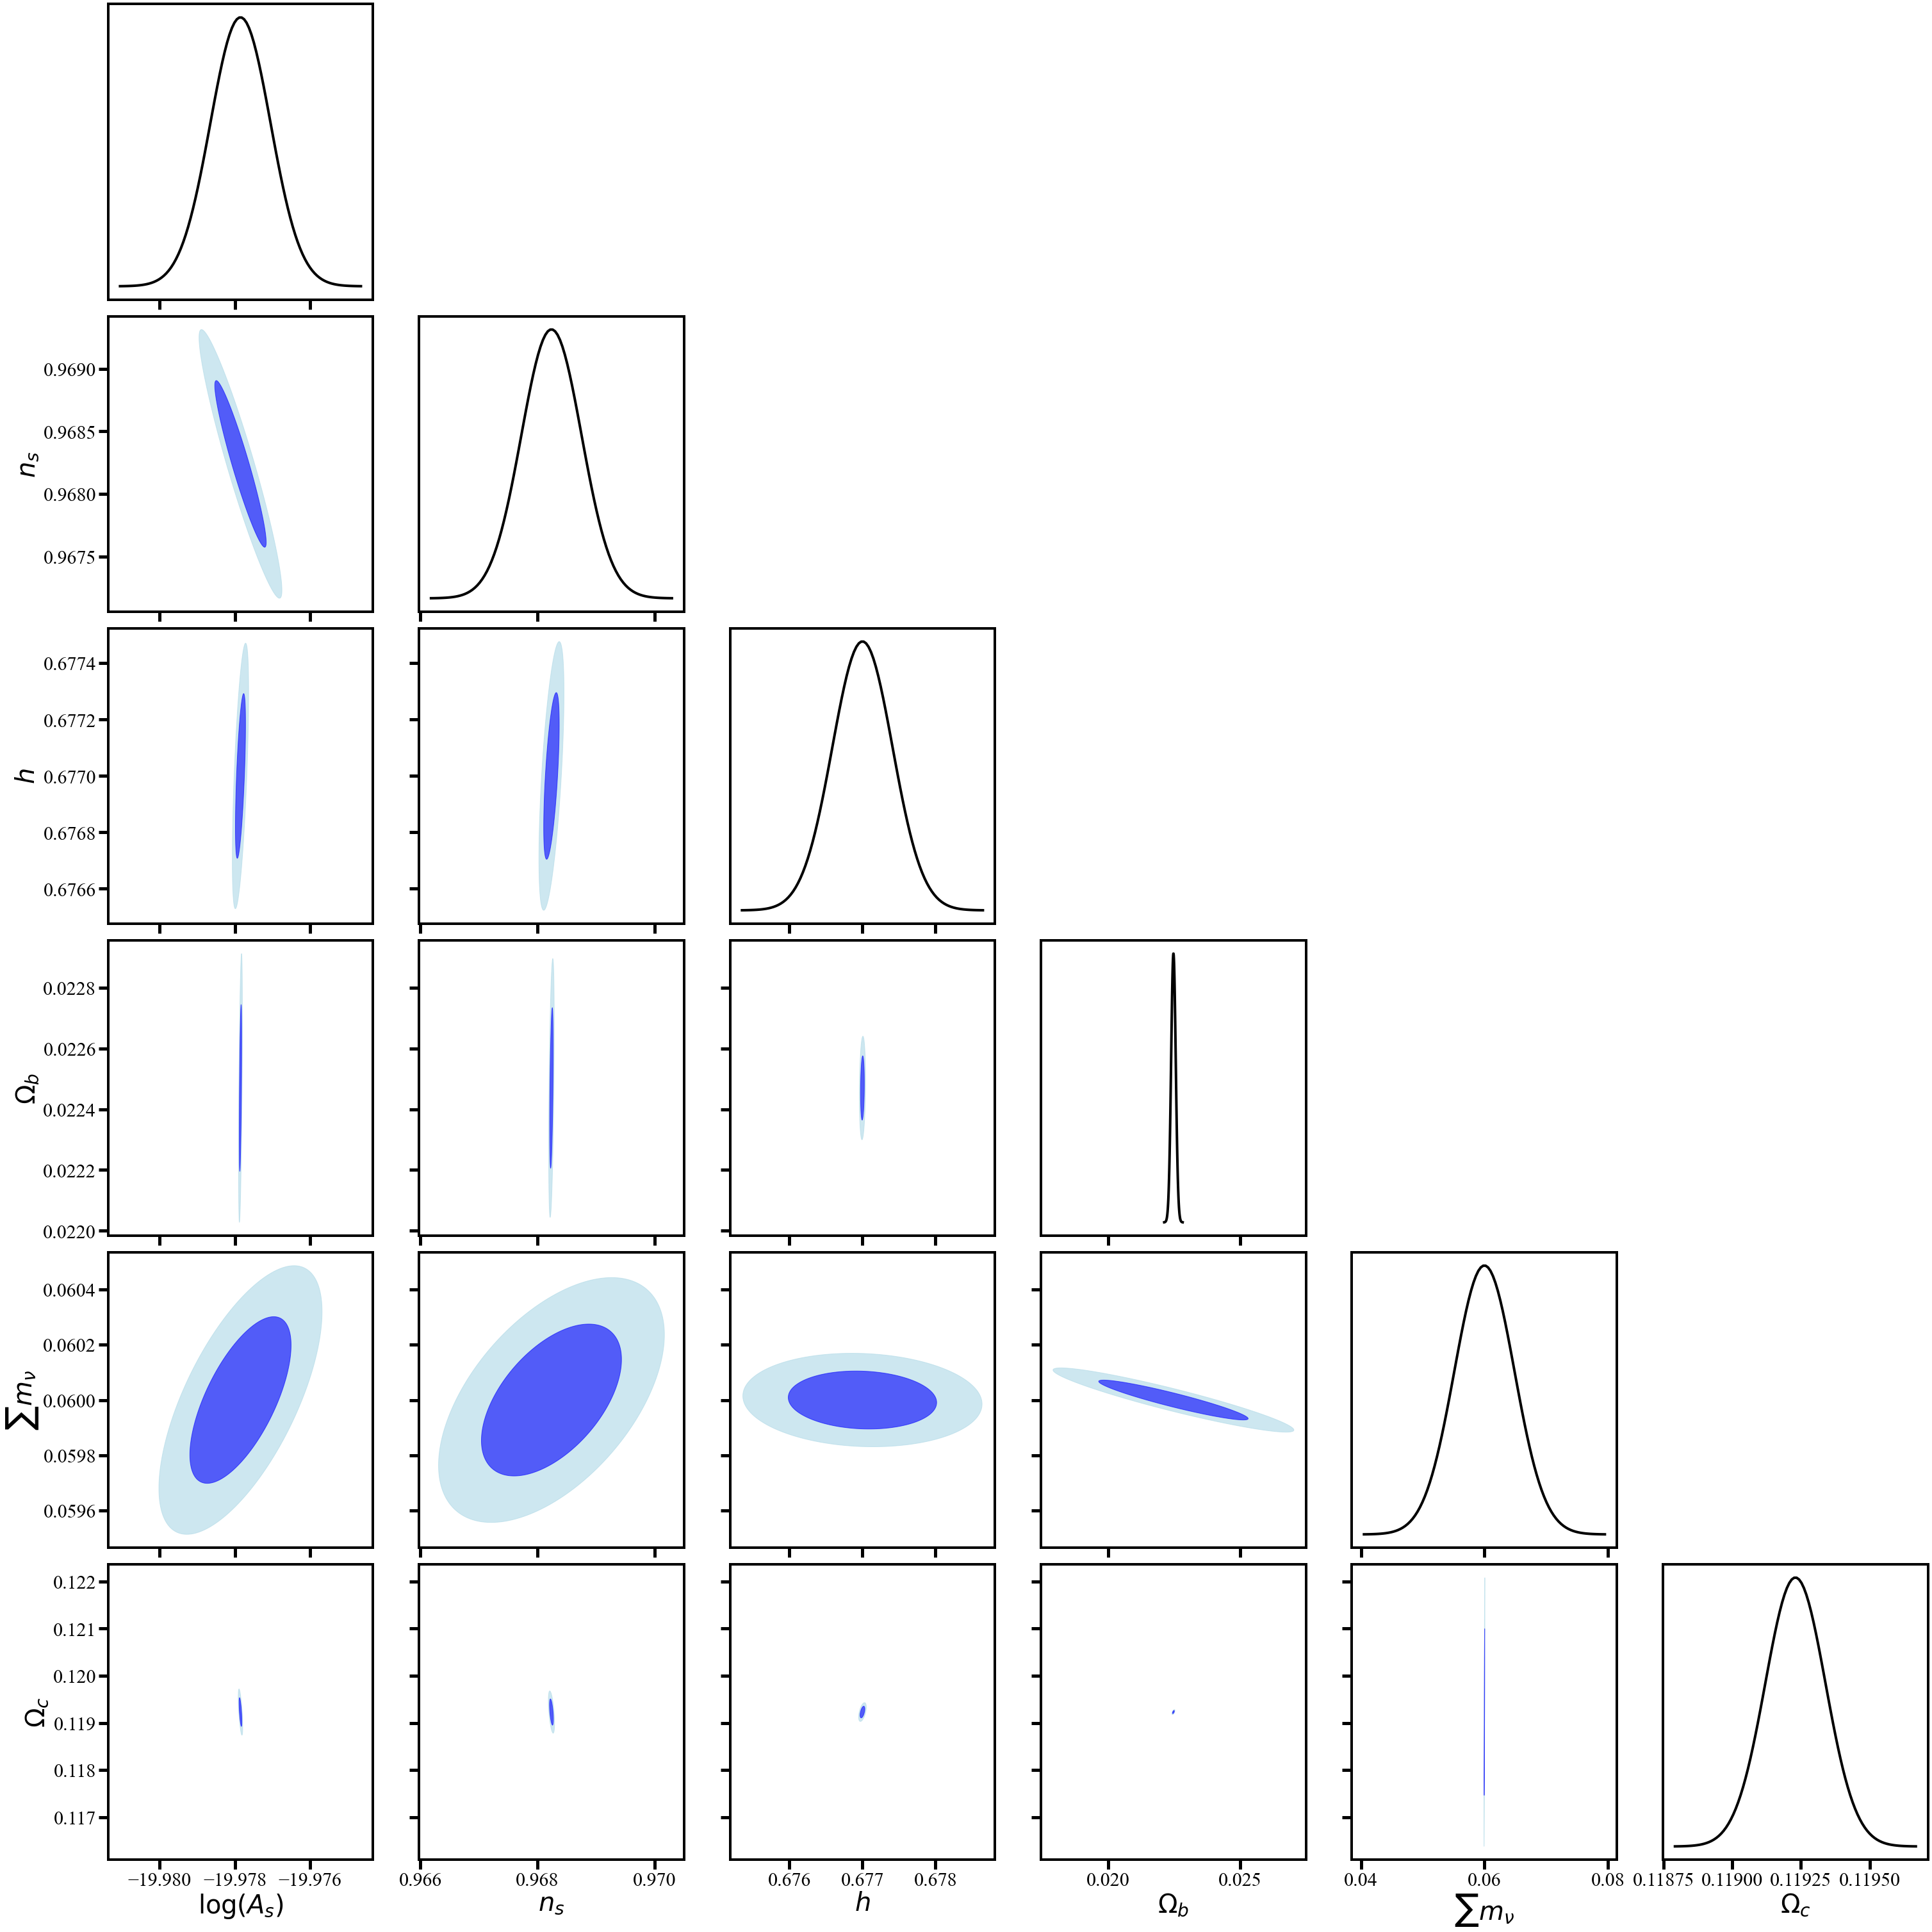

In [23]:
pumaCast.plot_posterior_matrix(F=F)

# Including Early Dark Energy (EDE)

In [24]:
exp = experiment(zmin=0.8,zmax=1.2,n=1e-3,nbins=1,sigma_z=0.)
marg_params = np.array(['omega_b','omega_cdm','h','fEDE'])
fishcast = fisherForecast(experiment=exp,cosmo=cosmo,params=params,khmax=0.2,Nk=200,Nmu=200,marg_params=marg_params)

In [25]:
F = fishcast.compute_Fisher_matrix()

In [26]:
fishcast.print_marginalized_errors(F=F)

Error on omega_b: 0.0007415308522567668
Error on omega_cdm: 0.0027426584226359677
Error on h: 0.010180194967379914
Error on fEDE: 0.03371946025144017


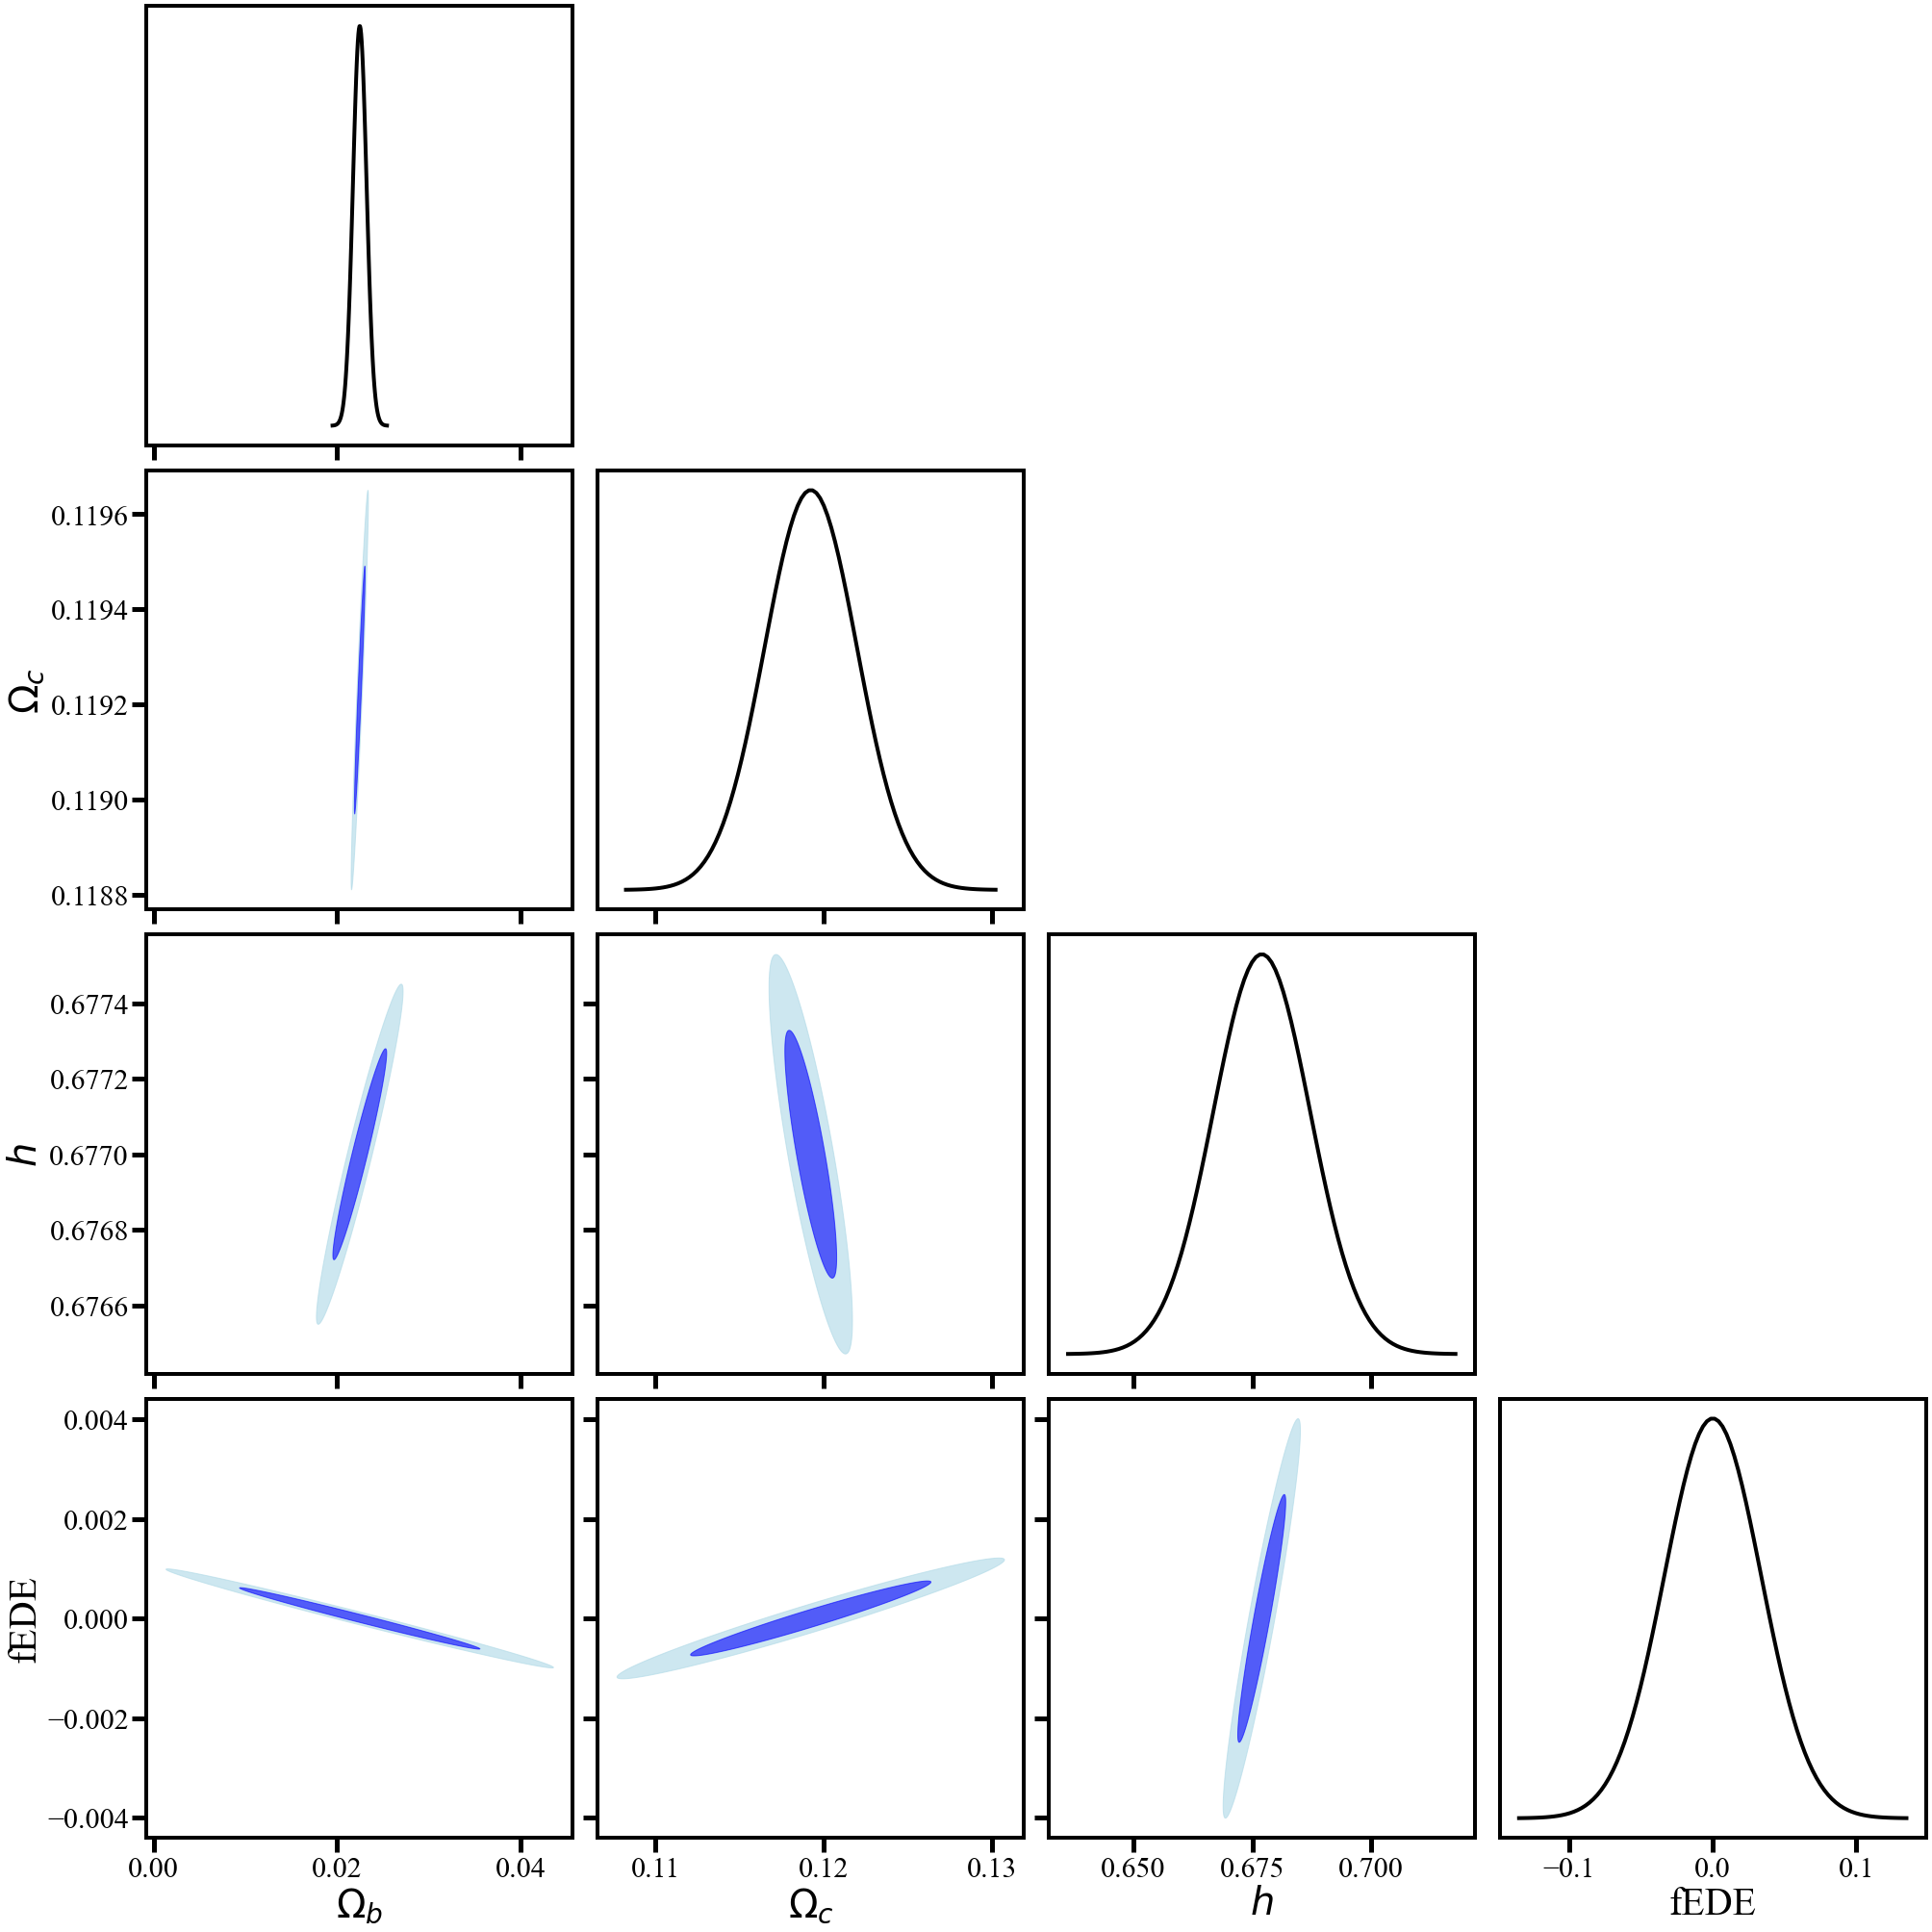

In [27]:
fishcast.plot_posterior_matrix(F=F)

# Features in the primordial power spectrum

In [28]:
exp = experiment(zmin=0.8,zmax=1.2,n=1e-3,nbins=1,sigma_z=0.)
marg_params = np.array(['omega_b','omega_cdm','h','A_lin'])
fishcast = fisherForecast(experiment=exp,cosmo=cosmo,params=params,khmax=0.2,Nk=200,Nmu=200,marg_params=marg_params)

In [29]:
F = fishcast.compute_Fisher_matrix()

In [30]:
fishcast.print_marginalized_errors(F=F)

Error on omega_b: 0.0009639610877786374
Error on omega_cdm: 0.001929159494334244
Error on h: 0.0076345379801403416
Error on A_lin: 0.012008539724507439


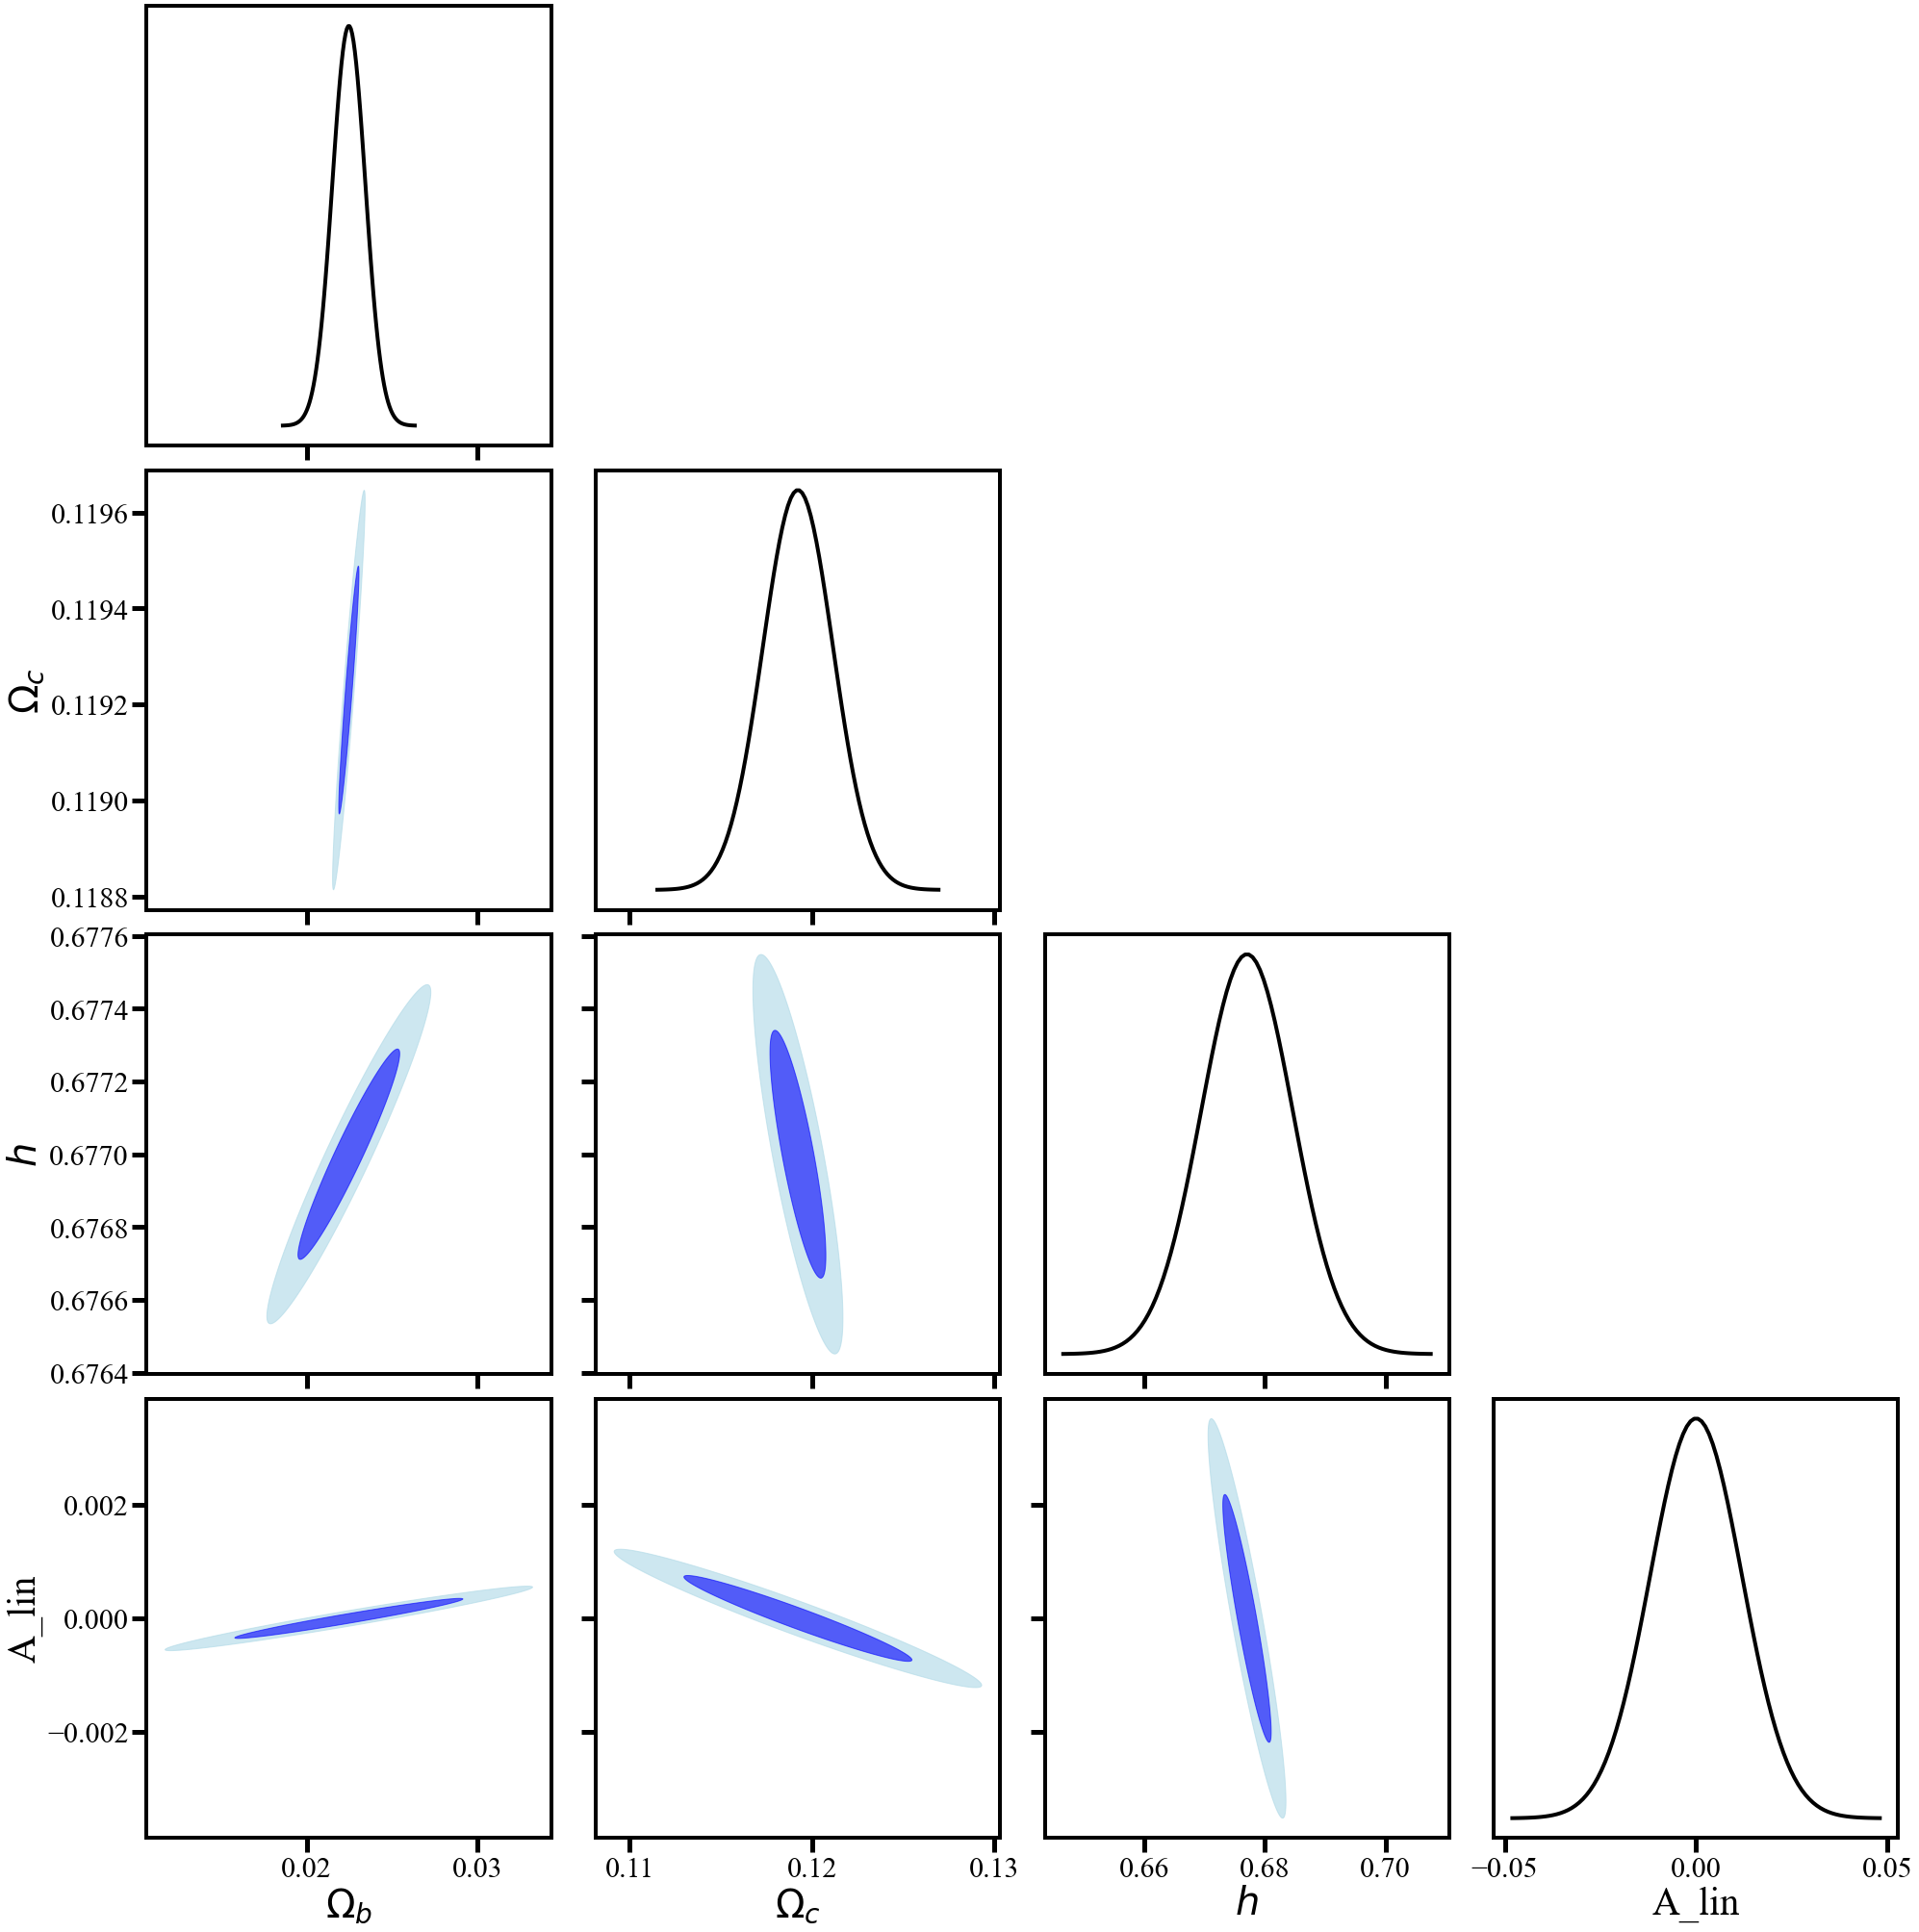

In [31]:
fishcast.plot_posterior_matrix(F=F)